In [1]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import datetime
import os
import time
import matplotlib.pyplot as plt
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.000498 s


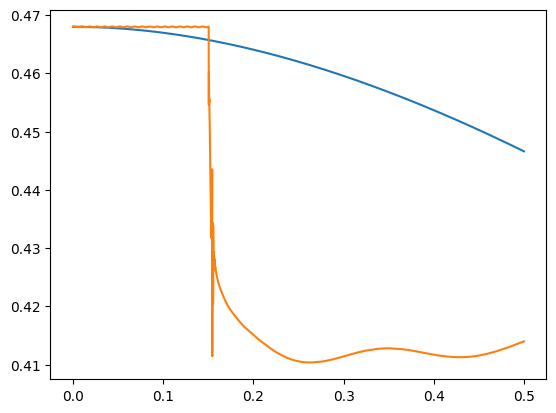

In [4]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import datetime
import os
import time
import matplotlib.pyplot as plt
import torch

class Load():
    def __init__(self, path=None, date=None, index=None, **kwargs):

        self.st = 0.
        self.et = 1.
        self.num_domain = 0
        self.num_boundary = 0
        self.num_test = None

        self.net = dde.nn.FNN([1] + [100] * 3 + [21], "swish", "Glorot uniform")


        self.method = "adam"
        self.lr = 0.0001
        self.period = 200
        self.iterations = 20000

  
        self.path = path
        self.date = date
        self.index = index

        if date is None:
            now = datetime.datetime.now()
            self.date = now.strftime("%m%d")
        if index is None:
            self.fnamevar_path = "Load_variables_ModelSave" + self.date + ".dat"
        else:
            self.fnamevar_path = "Load_variables_ModelSave" + self.date + "_" + str(index) + ".dat"

        self.set_variable()
        self.__dict__.update(kwargs)
        self.iterations = int(self.iterations)
        self.check_dat_file()


        input_data = pd.read_csv(path)
        step_time = input_data.Time[1] - input_data.Time[0]
        input_data.Time -= step_time * int(input_data.shape[0] * self.st)
        input_data = input_data[int(input_data.shape[0]*self.st): int(input_data.shape[0]*self.et)]

        self.input_data = input_data

        self.rename_csv()
        self.input_data['edp'] = 0
        self.input_data['eqp'] = 0
        Pzip = dde.Variable(self.init_Pzip)
        Qzip = dde.Variable(self.init_Qzip)
        alpha_1 = dde.Variable(self.init_alpha_1)
        alpha_2 = dde.Variable(self.init_alpha_2)
        alpha_4 = dde.Variable(self.init_alpha_4)
        alpha_5 = dde.Variable(self.init_alpha_5)
        a = dde.Variable(self.init_a)
        b = dde.Variable(self.init_b)
        c = dde.Variable(self.init_c)
        Hm = dde.Variable(self.init_Hm)
        xr = dde.Variable(self.init_xr)
        rr = dde.Variable(self.init_rr)
        xs = dde.Variable(self.init_xs)
        rs = dde.Variable(self.init_rs)
        xmu = dde.Variable(self.init_xmu)
        R_line = dde.Variable(self.init_R_line)
        X_line = dde.Variable(self.init_X_line)


        self.variable_list = [Pzip, Qzip, alpha_1, alpha_2, alpha_4, alpha_5, a, b, c, Hm, xr, xs, rr, xmu, rs, R_line, X_line]




        '''
        Here to set the lower and upper boundary of variables format: min-value and value-max
        '''
        def boundary_loss(size):
            loss = []
            with torch.no_grad():
                loss.append((torch.heaviside(torch.tensor(2e-2) - rs, torch.tensor(.0))/1e2).repeat(size))
                loss.append((torch.heaviside(torch.tensor(3e-1) - xs, torch.tensor(.0))/1e2).repeat(size))
                loss.append((torch.heaviside(torch.tensor(.75) - xmu, torch.tensor(.0))/1e2).repeat(size))
                loss.append((torch.heaviside(torch.tensor(3e-2) - rr, torch.tensor(.0))/1e2).repeat(size))
                loss.append((torch.heaviside(torch.tensor(3e-2) - xr, torch.tensor(.0))/1e2).repeat(size))
                loss.append((torch.heaviside(alpha_1 - torch.tensor(1.0), torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(torch.tensor(1e-6) - alpha_1, torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(alpha_2 - torch.tensor(1.0), torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(torch.tensor(1e-6) - alpha_2, torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(alpha_4 - torch.tensor(1.0), torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(torch.tensor(1e-6) - alpha_4, torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(alpha_5 - torch.tensor(1.0), torch.tensor(.0)) / 1e4).repeat(size))
                loss.append((torch.heaviside(torch.tensor(1e-6) - alpha_5, torch.tensor(.0)) / 1e4).repeat(size))
                # loss += torch.heaviside(alpha_1 - torch.tensor(1.0), torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(torch.tensor(1e-8) - alpha_1, torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(alpha_2 - torch.tensor(1.0), torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(torch.tensor(1e-8) - alpha_2, torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(alpha_4 - torch.tensor(1.0), torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(torch.tensor(1e-8) - alpha_4, torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(alpha_5 - torch.tensor(1.0), torch.tensor(.0)).repeat(size)
                # loss += torch.heaviside(torch.tensor(1e-8) - alpha_5, torch.tensor(.0)).repeat(size)
            return loss




        def ode(x, y):
            Id = y[:, 0: 1]
            Iq = y[:, 1: 2]
            Ws = y[:, 2: 3]
            Tm = y[:, 3: 4]
            Vd = y[:, 4: 5]
            Vq = y[:, 5: 6]
            P_im = y[:, 6: 7]
            Q_im = y[:, 7: 8]
            Wr = y[:, 8: 9]
            Te = y[:, 9: 10]
            I0 = y[:, 10: 11]
            V0 = y[:, 11: 12]
            P_poi = y[:, 12: 13]
            P_tot = y[:, 13: 14]
            P_dg = y[:, 14: 15]
            Q_poi = y[:, 15: 16]
            Q_tot = y[:, 16: 17]
            Q_dg = y[:, 17: 18]
            V_bus = y[:, 18: 19]
            edp = y[:, 19: 20]
            eqp = y[:, 20: 21]
            # differential equation parameter calculation
            Omega = 377     # 60Hz in rad/s
            x0 = xs + xmu
            xp = xs + (xr * xmu)/(xr + xmu)
            T0p = (xr + xmu)/(rr * Omega)
            # Equation 2 for sigma and Tm , Te, sigma = 1 - Wr, hence sigma_dt = - Wr_dt
            sigma_dt = - dde.grad.jacobian(y, x, i=8)
            edp_dt = dde.grad.jacobian(y, x, i=19)
            eqp_dt = dde.grad.jacobian(y, x, i=20)
            P_loss = P_poi + P_dg - (P_tot + P_im)
            Q_loss = Q_poi + Q_dg - (Q_tot + Q_im)

            alpha_3 = 1 - alpha_1 - alpha_2
            alpha_6 = 1 - alpha_4 - alpha_5
            return [
                # Due to the numerical precision error and per unit / real value mix, the equation should be verified before PINN running
                # Use the Data_Verification.ipynb file to make sure the equation is right
                # 2024-06-17 FUCK!!!!!!!!!!!! I HAVE TESTED IT FOR OVER A MONTH AND IT ALWAYS HAS A 1e-1 ERROR, WHERE THE FUCK ARE THESE ERRORS COME FROM???????
                # Equation 1 for Wr and Tm
                Tm - ( a + b * Wr + c * (Wr ** 2) ),
                # Equation 2 for sigma , Tm and Te
                sigma_dt - (Tm - Te)/(2 * Hm),
                # Equation 3 for differential
                # 这里要注意负号的方向和有名值计算
                - (Te * 0.15923) - ( edp * Id + eqp * Iq),
                edp - Vd - (rs * Id - xp * Iq),
                eqp - Vd - (rs * Iq + xp * Id),
                # edp_dt - ((Omega * (1-Wr) * eqp) - (edp + (x0 - xp) * Iq)/T0p),
                # eqp_dt - (- (Omega * (1-Wr) * edp) - (eqp - (x0 - xp) * Id)/T0p),
                # Equation 4 for ZIP load model
                P_tot - Pzip * (alpha_1 * (V_bus ** 2) + alpha_2 * (V_bus) + alpha_3),
                Q_tot - Qzip * (alpha_4 * (V_bus ** 2) + alpha_5 * (V_bus) + alpha_6),
                # Equation 5 for line loss
                P_loss - ((13.8 * V_bus) ** 2 / (R_line ** 2 + (Omega * X_line) ** 2)) * R_line,
                Q_loss - ((13.8 * V_bus) ** 2 / (R_line ** 2 + (Omega * X_line) ** 2)) * Omega * X_line,

                # constraints

                # (torch.nn.functional.relu(torch.tensor(.002) - rs) + torch.tensor(1e-1)).reshape(-1, 1)
                # torch.nn.functional.relu(0.03 - xs),
                # torch.nn.functional.relu(0.75 - xmu),
                # torch.nn.functional.relu(0.003 - rr),
                # torch.nn.functional.relu(0.003 - xr)
            ] + boundary_loss(Tm.size())



        self.ode = ode

    def check_dat_file(self):
        if os.path.exists(self.fnamevar_path):
            new_index = input(
                "The dat file already exists, please enter a new index to modify, or press Enter to continue---- \n")
            if new_index != '':
                self.index = new_index
                self.fnamevar_path = "Load_variables_ModelSave_" + self.date + "_" + str(new_index) + ".dat"
    
    def rename_csv(self):
        dict_col = {
            'Time': 'Time', 
            'I107d_rms': 'Idrms', 
            'I107q_rms': 'Iqrms', 
            'Omega107V': 'Ws', 
            'Tmpu_M1': 'Tmpu', 
            'V107d_rms': 'Vdrms', 
            'V107q_rms': 'Vqrms', 
            'PSTAT1M1': 'ph', 
            'QSTAT1M1': 'qh', 
            'SPDOUT1M1': 'Wr', 
            'TELECT1M1': 'Te',
            'I1070_rms': 'I0rms',
            'V1070_rms': 'V0rms',
            'P_POI1': 'P_poi',
            'Ptot_Area1': 'P_tot1',
            'P_DG': 'P_dg',
            'Q_POI1': 'Q_poi',
            'Qtot_Area1': 'Q_tot1',
            'Q_DG': 'Q_dg',
            'V101RMS': 'V101'
            }
        self.input_data.rename(columns=lambda x: dict_col[x.split('|')[-1]] if x.split('|')[-1] in dict_col.keys() else x, inplace=True)
        self.input_data = self.input_data[list(dict_col.values())]
        self.input_data.set_index('Time', inplace=True)
    
    def set_variable(self):


        self.init_Pzip = 1.
        self.init_Qzip = 1.
        self.init_alpha_1 = 1.
        self.init_alpha_2 = 1.
        self.init_alpha_4 = 1.
        self.init_alpha_5 = 1.
        self.init_a = 1.
        self.init_b = 1.
        self.init_c = 1.
        self.init_Hm = 1.
        self.init_xr = 1e-1
        self.init_rr = 4.5768e-2
        self.init_xs = 1e-1
        self.init_rs = 3e-2
        self.init_xmu = 9.
        self.init_R_line = 1.
        self.init_X_line = 1.



    def build(self, transform=None, **kwargs):
        if transform == ('input' or 'all'):
            self.net = dde.nn.FNN([6] + [100] * 3 + [4], "tanh", "Glorot uniform")
        self.__dict__.update(kwargs)
        input_data = self.input_data
        x = input_data.index.to_numpy()
        geom = dde.geometry.TimeDomain(0, x[-1])
        y = input_data.to_numpy()
        global y0
        y0 = y[0, :]
        observe_t = x.reshape(-1, 1)
        n = y.shape[0]
        y_real = y
        def boundary(_, on_initial):
            return on_initial
        observe_y0 = dde.icbc.PointSetBC(observe_t, y[:, 8:9], component=8) # Wr
        observe_y1 = dde.icbc.PointSetBC(observe_t, y[:, 3:4], component=3) # Tm
        observe_y2 = dde.icbc.PointSetBC(observe_t, y[:, 9:10], component=9) # Te
        observe_y3 = dde.icbc.PointSetBC(observe_t, y[:, 4:5], component=4)  # Ud
        observe_y4 = dde.icbc.PointSetBC(observe_t, y[:, 5:6], component=5)  # Uq
        observe_y5 = dde.icbc.PointSetBC(observe_t, y[:, 0:1], component=0)  # Id
        observe_y6 = dde.icbc.PointSetBC(observe_t, y[:, 1:2], component=1)  # Iq
        observe_y7 = dde.icbc.PointSetBC(observe_t, y[:, 18:19], component=18)  # Vbus
        observe_y8 = dde.icbc.PointSetBC(observe_t, y[:, 13:14], component=13)  # Ptot
        observe_y9 = dde.icbc.PointSetBC(observe_t, y[:, 16:17], component=16)  # Qtot
        observe_y10 = dde.icbc.PointSetBC(observe_t, y[:, 12:13], component=12)  # Ppoi
        observe_y11 = dde.icbc.PointSetBC(observe_t, y[:, 15:16], component=15)  # Qpoi
        observe_y12 = dde.icbc.PointSetBC(observe_t, y[:, 14:15], component=14)  # Pdg
        observe_y13 = dde.icbc.PointSetBC(observe_t, y[:, 17:18], component=17)  # Qdg
        observe_y14 = dde.icbc.PointSetBC(observe_t, y[:, 6:7], component=6)  # Pim
        observe_y15 = dde.icbc.PointSetBC(observe_t, y[:, 7:8], component=7)  # Qim

        data = dde.data.PDE(
            geom,
            self.ode,
            [observe_y0, observe_y1, observe_y1, observe_y2, observe_y3, observe_y4, observe_y5, observe_y6, observe_y7, observe_y8, observe_y9, observe_y10, observe_y11, observe_y12, observe_y13, observe_y14, observe_y15],
            # [],
            anchors=observe_t,
        )

        if transform is not None:
            from deepxde.backend import torch
            tran_in = False
            tran_out = False
            if transform == 'input':
                tran_in = True
            if transform == 'output':
                tran_out = True
            if transform == 'all':
                tran_in = True
                tran_out = True

            def feature_transform(t):
                t = 0.01 * t
                return torch.concat(
                    (
                        t,
                        torch.sin(t),
                        torch.sin(2 * t),
                        torch.sin(3 * t),
                        torch.sin(4 * t),
                        torch.sin(5 * t),
                    ),
                    axis=1,
                )

            data_t = observe_t
            data_y = y
            y_0 = torch.as_tensor(y0)
            def output_transform(t, y):
                idx = n - 1
                
                k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
                b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (
                        data_t[idx] - data_t[0]
                )
                linear = torch.as_tensor(k) * t + torch.as_tensor(b)
                factor = torch.tanh(t) * torch.tanh(idx - t)
                y2 = linear + factor * torch.Tensor([1 for _ in range(21)]) * y
                return y_0 * torch.exp(-t) + (1-torch.exp(-t))*y2

            if tran_in:
                self.net.apply_feature_transform(feature_transform)
            if tran_out:
                self.net.apply_output_transform(output_transform)

        model = dde.Model(data, self.net)
        model.compile(self.method, lr=self.lr,
                    #    loss_weights=[1,10,1,1,1], 
                       external_trainable_variables=self.variable_list)

        self.model = model
        self.x = x
        self.y = y
        self.observe_t = observe_t

    def train(self):
        fnamevar = self.fnamevar_path
        variable = dde.callbacks.VariableValue(self.variable_list, period=self.period, filename=fnamevar)
        if self.index is None:
            check_point_path = 'save_model/model_' + self.date + '.ckpt'
        else:
            check_point_path = 'save_model/model_' + self.date + '_' + str(self.index) + '.ckpt'
        checker= dde.callbacks.ModelCheckpoint(check_point_path, save_better_only = True, period = 100000)
        self.model.train(iterations=self.iterations, callbacks=[variable, checker])

    def load_model(self, model_path, load_fnamevar_path = None):
        if load_fnamevar_path is None:
            try:
                load_fnamevar_path = self.fnamevar_path
                lines = open(load_fnamevar_path, "r").readlines()
                Chat = np.array(
                    [
                        np.fromstring(
                            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
                            sep=",",
                        )
                        for line in lines
                    ]
                )
                self.init_PQkp = Chat[-1, 0]
                self.init_PQki = Chat[-1, 1]
                self.init_Ikp = Chat[-1, 2]
                self.init_Iki = Chat[-1, 3]

                print('Load variable values from ' + load_fnamevar_path)

            except:
                pass
        else:
            lines = open(load_fnamevar_path, "r").readlines()
            Chat = np.array(
                [
                    np.fromstring(
                        min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
                        sep=",",
                    )
                    for line in lines
                ]
            )


if __name__ == "__main__":

    input_data_path = 'Load_data/0616_island_IM.csv'

    microgird = Load(path=input_data_path,
                    # st=0.2,
                    # et=0.5,
                    # index = None
                    )


    '''
    while the message shows the output transform has met with unexpected error, uncomment these 2 lines to get the shape of output
    '''
    # microgird.build()
    # print(microgird.input_data.shape)



    microgird.build(transform='all',
                    net=dde.nn.FNN([6] + [100] * 3 + [21], "swish", "Glorot uniform"),
                    lr=1e-3,
                    iterations=6000000)
    # microgird.load_model('save_model/model_testNone.ckpt-200000.pt',
    #                      load_fnamevar_path = 'Load_variables_ModelSave_0301.dat')
    # microgird.train()



    # y_hat = microgird.model.predict(microgird.observe_t)
    # plt.plot(y_hat, microgird.observe_t)


    microgird.load_model('save_model/model_0618_island.ckpt-3000000.pt',
                         load_fnamevar_path = 'Load_variables_ModelSave_0618_island.dat')
    
    y_hat = microgird.model.predict(microgird.observe_t)
    plt.plot(microgird.observe_t, y_hat[:,4], microgird.observe_t, microgird.y[:, 4])

In [5]:
y_hat.shape

(5000, 21)